In [1]:
cd ..

/home/abdalrhman/Desktop/Graduation Project/AiStore/Recommender_V1


# 1. Setup & Imports

In [2]:
# Cell 1: Setup & Imports
import os
import sys
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import to_undirected
from srcs.utils.logger import get_module_logger
from srcs.utils.settings import (
    CLEANED_REVIEWS_PATH_CSV,
    CLEANED_METADATA_PATH_CSV,
    FULL_GRAPH_PATH,
    TRAIN_GRAPH_PATH,
    VAL_GRAPH_PATH,
    TEST_GRAPH_PATH,
    IMAGES_DIR,
    BATCH_TRAIN_LOADERS_PATH,
    BATCH_VAL_LOADERS_PATH,
    BATCH_TEST_LOADERS_PATH,
    MODEL_SAVE_PATH, 
    CHECKPOINT_PATH,
    
)

# Define project paths
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir, os.pardir))
sys.path.append(PROJECT_ROOT)

# Initialize logger
logger = get_module_logger("graph_builder")

# 2. Data Loading with Metadata Filtering

In [ ]:
# Load and filter data
reviews_df = pd.read_csv(CLEANED_REVIEWS_PATH_CSV)
meta_df = pd.read_csv(CLEANED_METADATA_PATH_CSV)

# Critical Fix: Ensure meta_df only contains items present in reviews
original_meta_size = len(meta_df)
meta_df = meta_df[meta_df['parent_asin'].isin(reviews_df['parent_asin'])]
logger.info(f"Filtered metadata: {original_meta_size} → {len(meta_df)} items")

logger.info(
    f"Loaded {len(reviews_df):,} reviews and {len(meta_df):,} metadata items. "
    f"{len(reviews_df['parent_asin'].unique()):,} unique items in reviews."
)

[2025-05-08 12:38:51] [INFO] graph_builder: Loaded 13472190 reviews and 13513 metadata items.


In [4]:
reviews_df.head(5)

,user_id,parent_asin,rating,timestamp,year,month,day,hour,minute,recency,recency_weight
0,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0047T79VS,3.0,2012-08-08 06:08:03.000,2012,8,8,6,8,4650,0.000215
1,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B01HHURN3W,3.0,2014-08-25 19:42:23.000,2014,8,25,19,42,3903,0.000256
2,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B017T99JPG,5.0,2016-02-29 18:59:25.000,2016,2,29,18,59,3350,0.000298
3,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B01LW71IBJ,5.0,2016-02-29 19:02:51.000,2016,2,29,19,2,3350,0.000298
4,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B09S6Y5BRG,5.0,2018-11-04 18:40:31.659,2018,11,4,18,40,2371,0.000422


In [5]:
meta_df.head(5)

,main_category,title,average_rating,rating_number,price,store,parent_asin,n_features,n_description_items,first_image,brand,color,date_first_available,primary_category,rating_bin
0,Computers,Digi-Tatoo Decal Skin Compatible With MacBook ...,4.5,246,19.99,Digi-Tatoo,B07SM135LS,5,0,https://m.media-amazon.com/images/I/31t4bj9t88...,Digi-Tatoo,Fresh Marble,2019-06-03,Electronics,Medium
1,Amazon Fashion,NotoCity Compatible with Vivoactive 4 band 22m...,4.5,233,9.99,Notocity,B089CNGZCW,5,0,https://m.media-amazon.com/images/I/41j56fjX6S...,Unknown,Unknown,2020-05-29,Electronics,Medium
2,Cell Phones & Accessories,Motorola Droid X Essentials Combo Pack,3.8,64,14.99,Verizon,B004E2Z88O,3,1,https://m.media-amazon.com/images/I/51-DXSMlHa...,Unknown,Unknown,2010-11-26,Electronics,Medium
3,Cell Phones & Accessories,"QGHXO Band for Garmin Vivofit 4, Soft Silicone...",4.4,707,14.89,Qghxo,B07BJ7ZZL7,5,10,https://m.media-amazon.com/images/I/51UefzXMzv...,Unknown,5Pcs Bands-Girl,2018-03-17,Electronics,Medium
4,Cell Phones & Accessories,May Chen Compatible with MacBook Pro 16 inch C...,4.5,649,26.99,May Chen,B0822SL7JX,5,1,https://m.media-amazon.com/images/I/51mR3hFRLs...,May Chen,Abstract Leaves,2023-02-06,Electronics,Medium


In [ ]:
# Encode nodes with filtered meta_df
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

reviews_df['user_id_enc'] = user_encoder.fit_transform(reviews_df['user_id'])
reviews_df['item_id_enc'] = item_encoder.fit_transform(reviews_df['parent_asin'])

# Encode meta_df after fitting on reviews
meta_df['item_id_enc'] = item_encoder.transform(meta_df['parent_asin'])

# Create bipartite node IDs
num_users = reviews_df['user_id_enc'].nunique()
num_items = reviews_df['item_id_enc'].nunique()
reviews_df['item_node'] = reviews_df['item_id_enc'] + num_users
reviews_df['user_node'] = reviews_df['user_id_enc']

# Directed edge construction (user -> item)
edge_index = torch.tensor(reviews_df[['user_node', 'item_node']].values.T, 
                dtype=torch.long)

[2025-05-08 12:39:04] [INFO] graph_builder: # Users: 1636018, # Items: 367983


In [7]:
# Cell 4: Construct Edge Index
reviews_df['item_node'] = reviews_df['item_id_enc'] + num_users
reviews_df['user_node'] = reviews_df['user_id_enc']
edge_index = torch.tensor(reviews_df[['user_node','item_node']].values.T, dtype=torch.long)
edge_index = to_undirected(edge_index)

In [8]:
# # Cell 5: Build Feature Matrix
# num_cols = ['average_rating','rating_number','price','n_features','n_description_items']
# meta_df[num_cols] = StandardScaler().fit_transform(meta_df[num_cols].fillna(0))
# cat_cols = ['main_category','brand','color','rating_bin']
# for col in cat_cols:
#     meta_df[col] = LabelEncoder().fit_transform(meta_df[col].astype(str))
# item_feats = torch.tensor(
#     meta_df.sort_values('item_id_enc')[num_cols + cat_cols].values,
#     dtype=torch.float
# )
# user_feats = torch.zeros((num_users, item_feats.size(1)), dtype=torch.float)
# x = torch.cat([user_feats, item_feats], dim=0)

# Cell 5: Build Feature Matrix (fixed for missing-item zero-fill)

# 1) Scale numeric metadata
num_cols = ['average_rating','rating_number','price','n_features','n_description_items']
meta_df[num_cols] = StandardScaler().fit_transform(meta_df[num_cols].fillna(0))

# 2) Encode categoricals
cat_cols = ['main_category','brand','color','rating_bin']
for col in cat_cols:
    meta_df[col] = LabelEncoder().fit_transform(meta_df[col].astype(str))

# 3) Determine sizes
num_users = reviews_df['user_id_enc'].nunique()
num_items = reviews_df['item_id_enc'].nunique()
feat_dim  = len(num_cols + cat_cols)

# 4) Initialize full item‐feature tensor
item_feats = torch.zeros((num_items, feat_dim), dtype=torch.float)

# 5) Fill in known metadata for items that appear in meta_df
known_ids   = meta_df['item_id_enc'].values
known_feats = torch.tensor(meta_df.sort_values('item_id_enc')[num_cols + cat_cols].values,
                           dtype=torch.float)
item_feats[known_ids] = known_feats

# 6) Dummy user features
user_feats = torch.zeros((num_users, feat_dim), dtype=torch.float)

# 7) Concatenate into node feature matrix
x = torch.cat([user_feats, item_feats], dim=0)

# 8) Sanity check
assert x.size(0) == num_users + num_items


In [9]:
from torch_geometric.data import Data

# This is the full graph before any edge split
full_graph_data = Data(x=x, edge_index=edge_index)

# Optional: Save it
torch.save(full_graph_data, FULL_GRAPH_PATH)


In [10]:
# Cell 6: Create PyG Data & Split Edges for Link Prediction
from torch_geometric.transforms import RandomLinkSplit

# RandomLinkSplit configured for link prediction:
# - 10% val, 10% test
# - undirected graph
# - include negative train samples so train_data.edge_label_index exists
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0   # one negative per positive
)

train_data, val_data, test_data = transform(Data(x=x, edge_index=edge_index))

# Save splits
torch.save(train_data, TRAIN_GRAPH_PATH)
torch.save(val_data, VAL_GRAPH_PATH)
torch.save(test_data, TEST_GRAPH_PATH)
logger.info("Saved train, val, and test graphs using RandomLinkSplit.")


[2025-05-08 12:39:21] [INFO] graph_builder: Saved train, val, and test graphs using RandomLinkSplit.


In [11]:
# —— Validation of Splits —— 

# 1. Check that each split has the unified 'edge_label_index' and 'edge_label'
for split_name, d in [('Train', train_data),
                      ('Validation', val_data),
                      ('Test', test_data)]:
    assert hasattr(d, 'edge_label_index'), \
        f"{split_name} is missing 'edge_label_index'"
    assert hasattr(d, 'edge_label'), \
        f"{split_name} is missing 'edge_label'"

# 2. Check shapes of edge_label_index
assert train_data.edge_label_index.shape[0] == 2, \
    "train_data.edge_label_index should have shape [2, num_train_samples]"
assert val_data.edge_label_index.shape[0] == 2, \
    "val_data.edge_label_index should have shape [2, num_val_samples]"
assert test_data.edge_label_index.shape[0] == 2, \
    "test_data.edge_label_index should have shape [2, num_test_samples]"

# 3. No overlap between splits on the *labeled* edges
def edge_set(edge_label_index):
    return set(map(tuple, edge_label_index.t().tolist()))

train_edges = edge_set(train_data.edge_label_index)
val_edges   = edge_set(val_data.edge_label_index)
test_edges  = edge_set(test_data.edge_label_index)

assert train_edges.isdisjoint(val_edges), "Train & Val labeled edges overlap!"
assert train_edges.isdisjoint(test_edges), "Train & Test labeled edges overlap!"
assert val_edges.isdisjoint(test_edges), "Val & Test labeled edges overlap!"

# 4. Check that node features are carried through intact
assert train_data.x.size() == val_data.x.size() == test_data.x.size(), \
    "Node feature dimensions changed across splits"

# 5. Quick summary
print("[✓] RandomLinkSplit produced valid link‐prediction splits\n")

for split_name, d in [('Train', train_data),
                      ('Validation', val_data),
                      ('Test', test_data)]:
    n_samples = d.edge_label_index.size(1)
    n_pos     = (d.edge_label == 1).sum().item()
    n_neg     = (d.edge_label == 0).sum().item()
    print(f"{split_name}: total samples = {n_samples},  positive = {n_pos},  negative = {n_neg}")
print("Node feature shape:", train_data.x.shape)


[✓] RandomLinkSplit produced valid link‐prediction splits

Train: total samples = 21555504,  positive = 10777752,  negative = 10777752
Validation: total samples = 2694438,  positive = 1347219,  negative = 1347219
Test: total samples = 2694438,  positive = 1347219,  negative = 1347219
Node feature shape: torch.Size([2004001, 9])


In [12]:
# Cell 7: Report Graph Statistics
for split_name, g in [
    ('Train', train_data),
    ('Validation', val_data),
    ('Test', test_data)
]:
    num_nodes = g.num_nodes
    # Since edge_index is undirected, every edge appears twice
    num_edges = g.edge_index.size(1) // 2
    avg_degree = (2 * num_edges) / num_nodes

    logger.info(f"{split_name} Graph — Nodes: {num_nodes}, Edges: {num_edges}, Avg Degree: {avg_degree:.2f}")
    print(f"{split_name} Graph")
    print(f" - Number of nodes      : {num_nodes}")
    print(f" - Number of edges      : {num_edges}")
    print(f" - Average node degree  : {avg_degree:.2f}\n")


[2025-05-08 12:39:31] [INFO] graph_builder: Train Graph — Nodes: 2004001, Edges: 10777752, Avg Degree: 10.76


Train Graph
 - Number of nodes      : 2004001
 - Number of edges      : 10777752
 - Average node degree  : 10.76



[2025-05-08 12:39:31] [INFO] graph_builder: Validation Graph — Nodes: 2004001, Edges: 10777752, Avg Degree: 10.76


Validation Graph
 - Number of nodes      : 2004001
 - Number of edges      : 10777752
 - Average node degree  : 10.76



[2025-05-08 12:39:31] [INFO] graph_builder: Test Graph — Nodes: 2004001, Edges: 12124971, Avg Degree: 12.10


Test Graph
 - Number of nodes      : 2004001
 - Number of edges      : 12124971
 - Average node degree  : 12.10



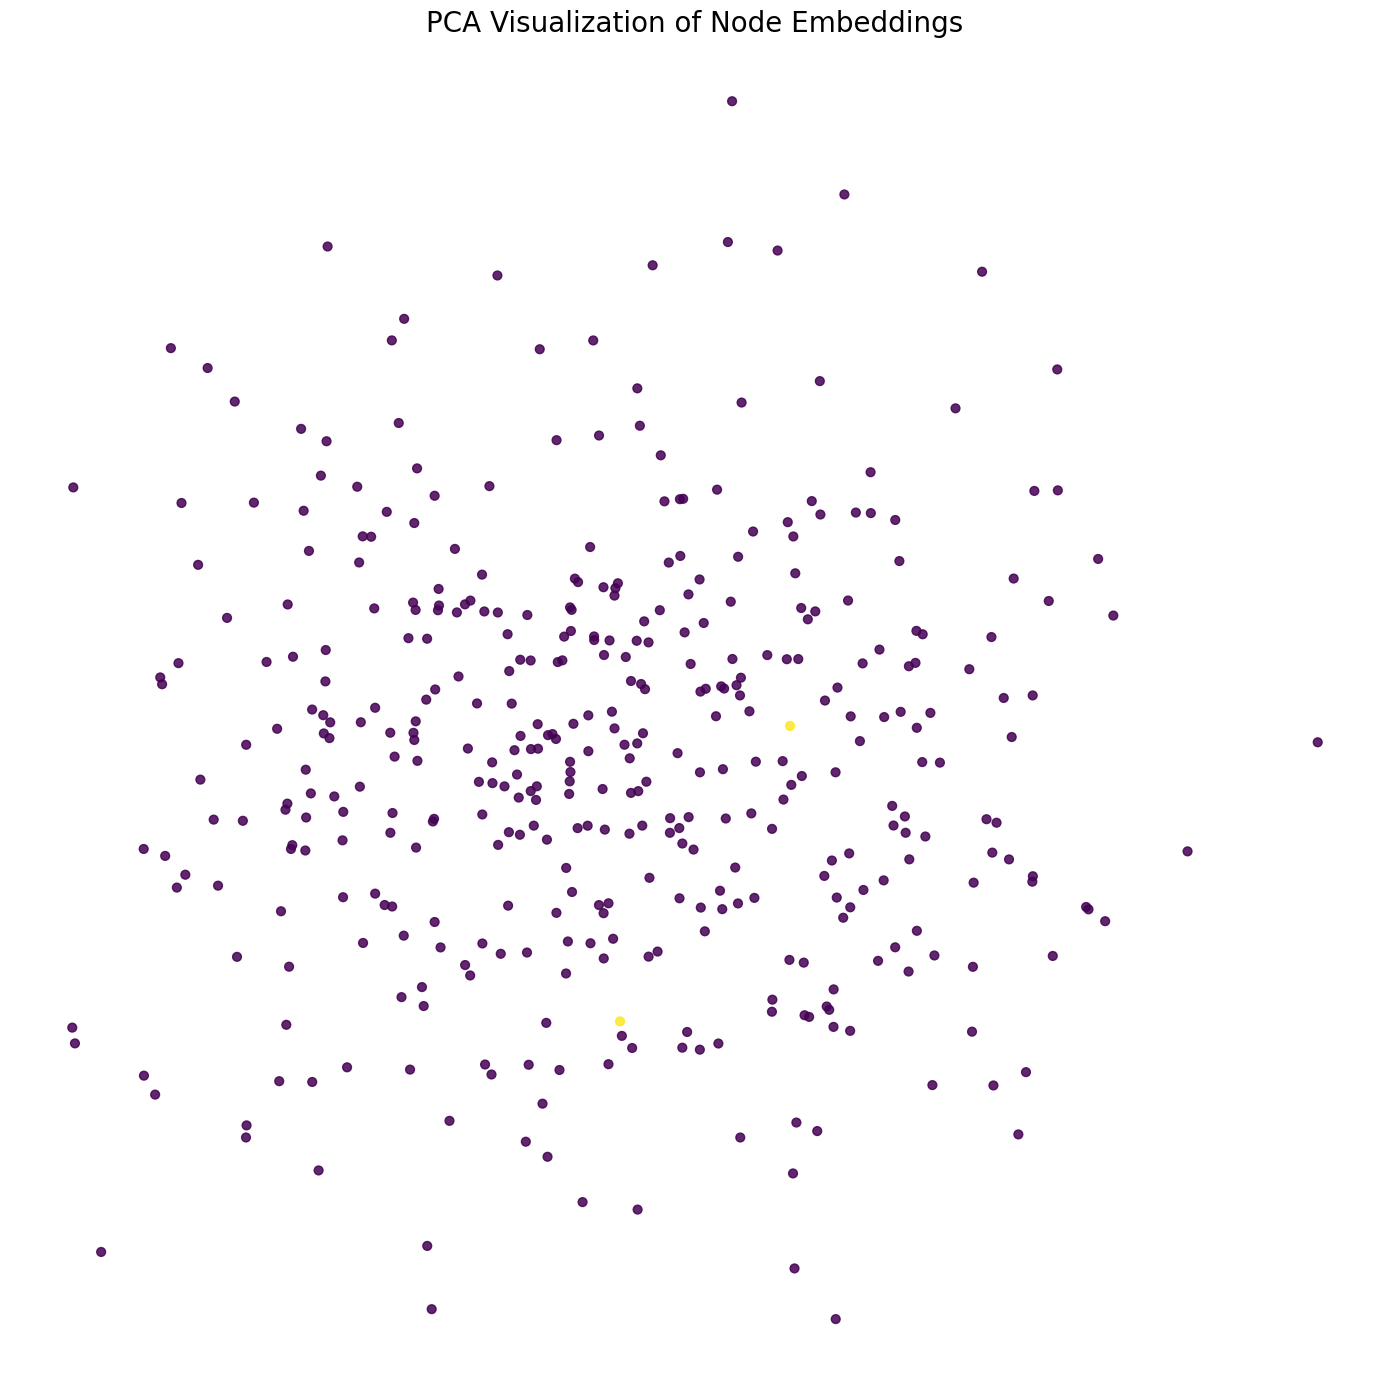

<Figure size 640x480 with 0 Axes>

In [13]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx, subgraph
from torch_geometric.data import Data
from sklearn.decomposition import PCA
import numpy as np

# Parameters
SUBGRAPH_NODE_COUNT = 1000
NODE_SIZE = 40
EDGE_WIDTH = 2

# Use your train_data
edge_index = train_data.edge_index

# Sample a subset of connected nodes
all_nodes = torch.unique(edge_index)
subset_nodes = all_nodes[torch.randperm(all_nodes.size(0))[:SUBGRAPH_NODE_COUNT]]

# Extract subgraph
sub_edge_index, _ = subgraph(subset_nodes, edge_index, relabel_nodes=True)

# Retry sampling until a subgraph with at least one edge is found
MAX_ATTEMPTS = 10
attempt = 0
while attempt < MAX_ATTEMPTS:
    subset_nodes = all_nodes[torch.randperm(all_nodes.size(0))[:SUBGRAPH_NODE_COUNT]]
    sub_edge_index, _ = subgraph(subset_nodes, edge_index, relabel_nodes=True)
    
    if sub_edge_index.numel() > 0:
        break
    attempt += 1

if sub_edge_index.numel() == 0:
    raise ValueError("Failed to find a valid subgraph with edges. Try increasing the node pool or check edge_index.")


subgraph_data = Data(edge_index=sub_edge_index, num_nodes=int(sub_edge_index.max()) + 1)

# Create dummy embeddings matching subgraph node count
node_embeddings = torch.rand((subgraph_data.num_nodes, 128))

# Reduce embeddings to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(node_embeddings.numpy())

# Node coloring by degree
G = to_networkx(subgraph_data, to_undirected=True)
G = nx.convert_node_labels_to_integers(G)
degrees = dict(G.degree())
node_color = [degrees[n] for n in G.nodes]

# Plot the 2D embeddings
plt.figure(figsize=(14, 14))
plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=node_color,
    cmap=plt.cm.viridis,
    s=NODE_SIZE,
    alpha=0.85
)
plt.title("PCA Visualization of Node Embeddings", fontsize=20)
plt.axis("off")
plt.tight_layout()
plt.show()

# save to IMAGES_DIR
plt.savefig(IMAGES_DIR, dpi=300)


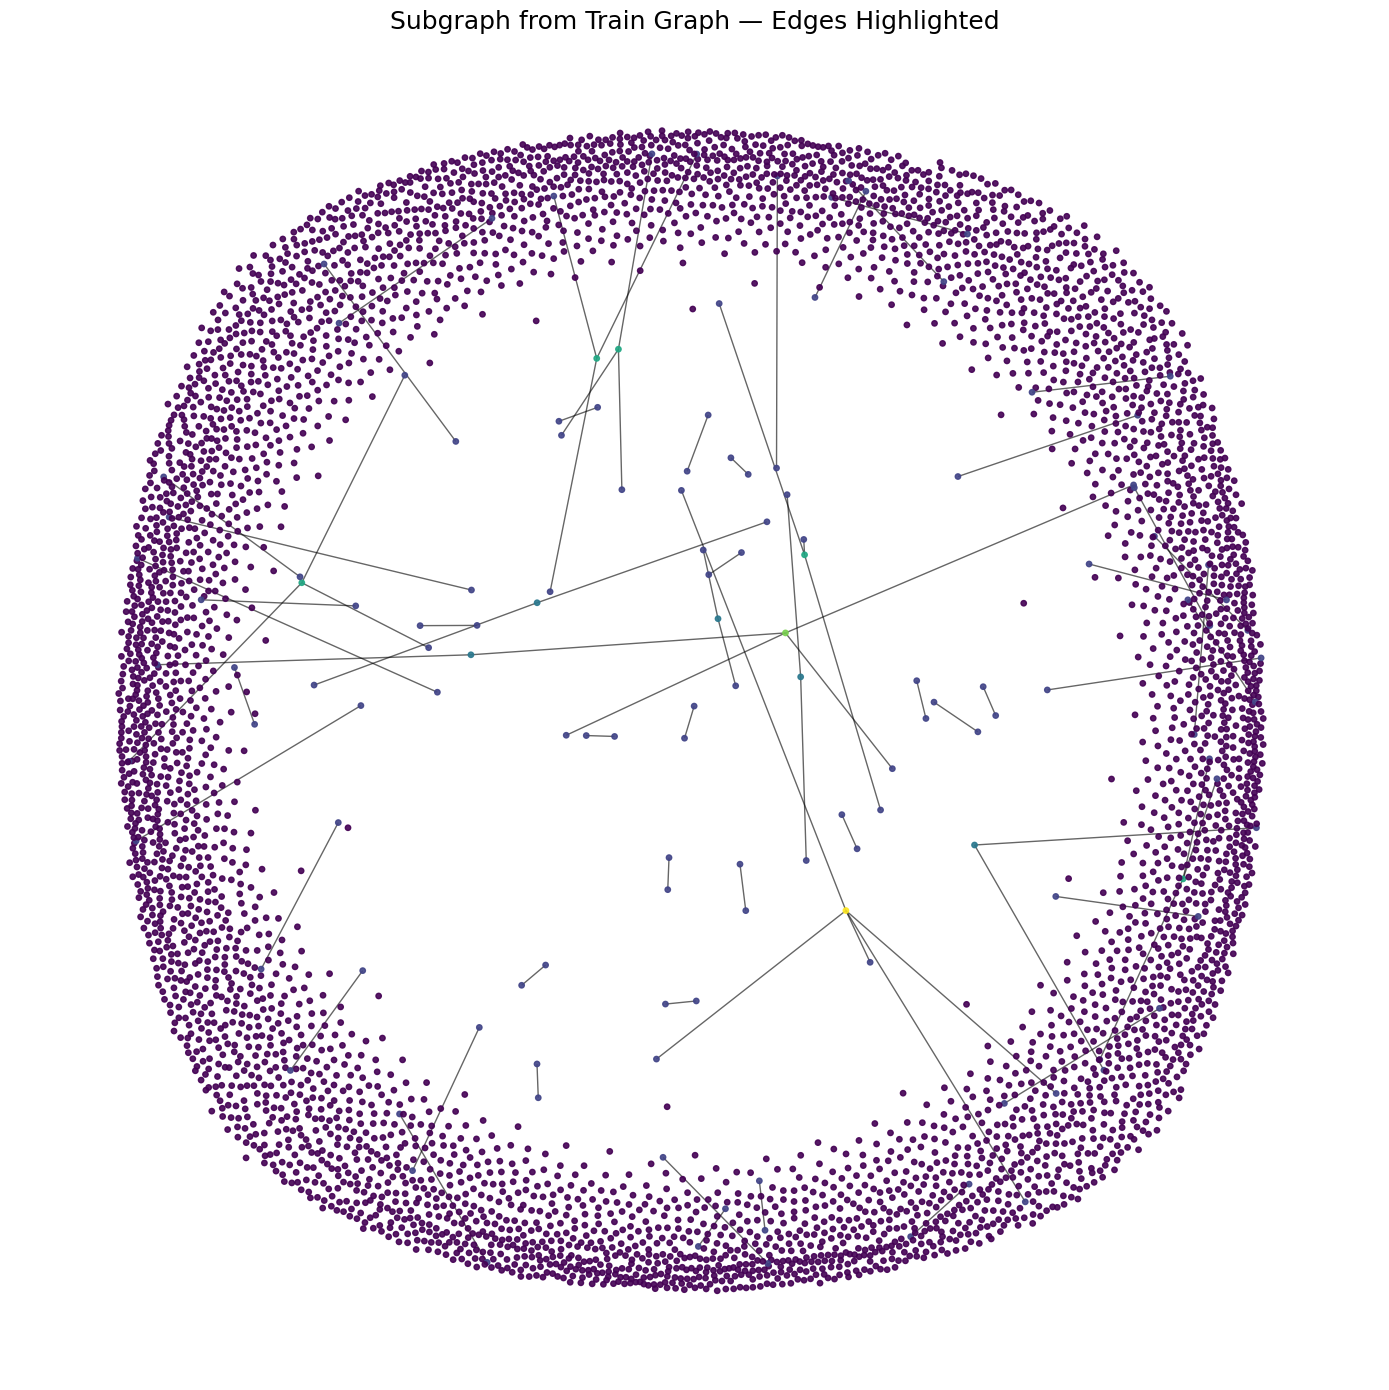

<Figure size 640x480 with 0 Axes>

In [14]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx, subgraph
from torch_geometric.data import Data

# Parameters
SUBGRAPH_NODE_COUNT = 5000
SPRING_LAYOUT_ITER = 30

# Use your existing train_data
edge_index = train_data.edge_index
num_nodes = train_data.num_nodes

# Sample a subset of nodes
all_nodes = torch.unique(edge_index)
subset_nodes = all_nodes[torch.randperm(all_nodes.size(0))[:SUBGRAPH_NODE_COUNT]]

# Extract the subgraph
sub_edge_index, _ = subgraph(subset_nodes, edge_index, relabel_nodes=True)
subgraph_data = Data(edge_index=sub_edge_index, num_nodes=SUBGRAPH_NODE_COUNT)

# Convert to NetworkX
G = to_networkx(subgraph_data, to_undirected=True)
G = nx.convert_node_labels_to_integers(G)

# Degree-based node coloring
degrees = dict(G.degree())
node_color = [degrees[n] for n in G.nodes]

# Layout
pos = nx.spring_layout(G, seed=42, k=0.1, iterations=SPRING_LAYOUT_ITER)

# Plot with visible edges
plt.figure(figsize=(14, 14))
nx.draw_networkx_edges(G, pos, alpha=0.6, width=1, edge_color="black")  # emphasize edges
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=15,
    node_color=node_color,
    cmap=plt.cm.viridis,
    alpha=0.9
)

plt.title("Subgraph from Train Graph — Edges Highlighted", fontsize=18)
plt.axis("off")
plt.tight_layout()
plt.show()

plt.savefig(IMAGES_DIR, dpi=300)